[7, 24, 42, 27]
[[0, 6], [6, 30], [30, 72], [72, 99]]
Layer 1 is in phase 1  of depth from 0.0km to 8067.0187712229335km
Layer 2 is in phase 1  of depth from 8067.0187712229335km to 40335.09385611467km
Layer 3 is in phase 2  of depth from 40335.09385611467km to 96804.2252546752km
Layer 4 is in phase 6  of depth from 96804.2252546752km to 133105.8097251784km
[1.90532955e+02 4.51605859e+05 1.22087180e+03 7.20885539e+06]
[ -8.46994684 -42.32717253 -89.56755847 -21.39387312]


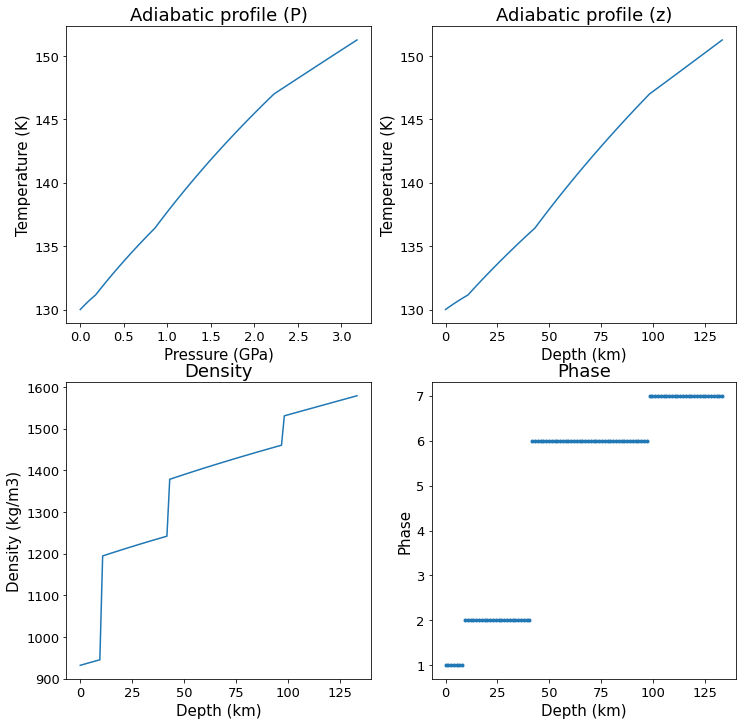

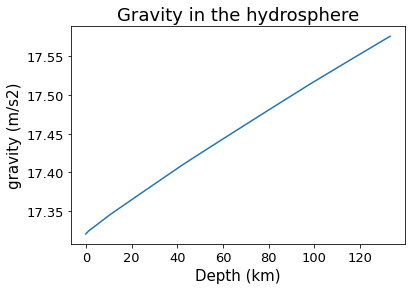

Variable                              Value
----------------------------  -------------
Pressure at surface (bar)       1
Temperature at surface (K)    130
Pressure at HMB (GPa)           3.17827
Temperature at HMB (K)        151.267
Surface Gravity:               17.3207
Planet Radius (m):              1.15333e+07
Hydrosphere Thickness (km)    133.106
Mass of water (kg):             2.99382e+23
Mass of water (Earth Ocean):  213.844
Mass of water (Earth Mass):     0.0501293
Mass difference (%):            0.205978


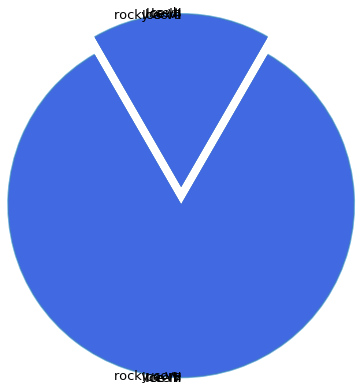

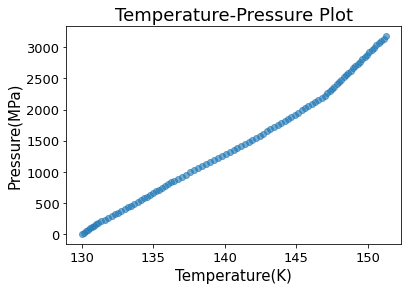

<Figure size 432x288 with 0 Axes>

In [35]:
# HydroSphere v0.7.2
# Computation of a water-rich planetary body adiabatic profile using SeaFreeze thermodynamics
# with Mass of water as an input
# Wei Dai & Baptiste Journaux 2020
import numpy as np
import seafreeze as sf
import matplotlib.pyplot as plt
import time
import json
from tabulate import tabulate
from scipy.optimize import minimize
from numpy import linalg as la
import warnings 

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Europa Ganymede

##### Inputs

# Data set: Ganymede; Europa; Titan; Earth; 50x ocean Earth; 1.8xR 100x ocean Earth
P_s_set = [0.7e-12, 0.1e-12, 0.1467, 0.1, 0.1, 0.1, 0.1]
T_s_set = [130, 130, 90, 300, 300, 300, 130]
Mass_W_i_set = [1.5e+22, 3e+18, 7.2e+22, 1.4e+21, 7e+22, 1.4e+23, 3e23]
r_b_set = [1.63e+06, 1.46e+06, 2.58e+06, 6.36e+06, 6.36e+06, 1.14e+07, 1.14e7]
rho_core_set = [5500, 3040, 1880, 5514, 5514, 5514, 5514]


# P_s = 0.1 (constant)
# T_s = 263 -> 373 ; 5 steps
# Mass_W_i = 1.4e+21 -> *100 1.4e+21 ; 5 steps
# r_b = 0.6*6.36e+06 -> 1.8*6.36e+06 ; 5 steps
# rho_core = 5514 (constant)

# 0:Ganymede; 1:Europa; 2:Titan; 3:Earth; 4:50x ocean Earth; 5:1.8xR 100x ocean Earth
target_planet = 6

# data can change arbitrarily
P_s = P_s_set[target_planet]   # Surface Pressure (MPa);
T_s = T_s_set[target_planet]   # Surface Temperature (K);
Mass_W_i = Mass_W_i_set[target_planet]    # Mass of water in kg;
r_b = r_b_set[target_planet]              #1*6370*1e3  # Radius rocky core (m);
rho_core = rho_core_set[target_planet]    # density of the rocky core (kg/m3);

##### Resolution
#computation time /profile tools 
res = 100;  # z grid
Mass_it = 5 # Mass convergence iteration: 3-5 is enough (check % Mass difference)
g_it = 2;  # Gravity convergence iteration (3 is enough)

##### Plots and table
plot_flg = 1 # plot flag: 0=no plot; 1=plot
tab_flg = 1 # Table flag: 0=no table; 1=table
gravity_flg = 1 # gravity profile flag: 0=no plot; 1=plot
writefile_flg = 0 # Output file flag: 0=no output file; 1=output file
IO_flg = 0 # Output input/output file flag: 0=no output file; 1=output file
rawdata_flg = 0 # Output the raw data in columns; 1=output
piechart_flg = 1 # plot a pie chart: 0=no plot; 1=plot
scatterplt_flg = 1 # plot a scatter point between P and T: 0=no plot; 1=plot

#### Threshold 
# Mass covergence loop threshhold, in percentage
mass_thrshd = 1

#############################################

# Ice VII approximation
rho_VII = 1.6169e+03
alpha_VII = 2.45e-4
Cp_VII = 3400

# Ice Ih conductivity (Andersson and Akira, 2005) 
def K_Ih(P,T):
    return -2.04104873*P+(632/T+0.38-0.00197*T)

# Rocky/metal core calculation
Mass_core = 4/3*np.pi*r_b**3*rho_core
g_s = 6.67430e-11*Mass_core/r_b**2 # Gravity at the Hydrosphere Mantle Boundary
depth = (Mass_W_i/800/(4/3*np.pi)+r_b**3)**(1/3)-r_b # Depth approximation in m

# Testing factors
massDiff = 100
EnableTest = 0 #0=disable, 1=enable


# initializing the grids
z = np.linspace(0, depth, num=res)  # depth grid
rho = np.zeros(z.size)  # Density grid
alpha = np.zeros(z.size)  # thermal epansivity grid
Cp = np.zeros(z.size)  # Heat capacity grid
dT_dz = np.zeros(z.size)  # thermal gradient grid
phase = np.zeros(z.size)  # phase grid
T = np.zeros(z.size)  # Temperature grid
P = np.zeros(z.size)  # Pressure grid
grav = np.zeros(z.size) # gravity grid
M_L = np.zeros(z.size) # Mass grid

Mass_WL = 0

while (massDiff > mass_thrshd):
    if EnableTest == 1:
        print("depth before " + str(depth))
        
    # For mass loop the factor being iterated is /depth/
    
    # initializing the grids
    z = np.linspace(0, depth, num=res)  # depth grid
        
    grav[:]=g_s # Constant gravity to start with ## set all elements to g_s
    
    massDiff = np.abs(100*(Mass_W_i-Mass_WL)/Mass_W_i)
    #print(massDiff)
    
    # Gravity conversion loop
    for k in range(g_it) if (massDiff==100 or massDiff<mass_thrshd) else range(1): 

        # For gravity loop the factor being iterated is /grav/

        g = np.flip(grav,0)
        PT = np.empty((1,), np.object)
        PT[0] = (P_s, T_s)
        #phase_ssolution = sf.whichphase(PT)  # not necessary 
        if P_s > 2200:
            #out.rho = rho_VII
            #out.alpha = alpha_VII
            #out.Cp = Cp_VII
            phase_s[0] = 7   
            out = sf.seafreeze(PT, sf.phasenum2phase[7])
        else:
            phase_s = sf.whichphase(PT)
            out = sf.seafreeze(PT,sf.phasenum2phase[phase_s[0]]) 

        rho_s = out.rho  # Density at the surface
        alpha_s = out.alpha  # Thermal expansivity at the surface
        Cp_s = out.Cp  # Heat capacity at the surface
        dT_dz_s = alpha_s*g[0]*T_s/Cp_s  # Thermal gradient at the surface
        T[0] = T_s
        P[0] = P_s
        rho[0] = rho_s
        alpha[0] = alpha_s
        Cp[0] = Cp_s
        dT_dz[0] = dT_dz_s
        phase[0] = phase_s[0]
        

        for i in range(z.size-1):  # Integration with depth
            T[i+1] = T[i] + dT_dz[i] * (z[i+1]-z[i]);
            P[i+1] = P[i] + rho[i] * g[i] * (z[i+1]-z[i])*1e-6;
            PT[0] = (P[i+1],T[i+1])
            if P[i+1] > 2200:
                #out.rho = rho_VII
                #out.alpha = alpha_VII
                #out.Cp = Cp_VII
                phase[i+1] = 7
                out = sf.seafreeze(PT, sf.phasenum2phase[7])
            else:
                phase[i+1] = sf.whichphase(PT)
                out = sf.seafreeze(PT,sf.phasenum2phase[phase[i]])
            rho[i+1] = out.rho;
            alpha[i+1] = out.alpha;
            Cp[i+1] = out.Cp;
            dT_dz[i+1] = alpha[i+1]*g[i+1]*T[i+1]/Cp[i+1];

        # Gravity in the hydrosphere
        for i in range(1,len(rho)):
            M_L[i]=rho[i]*4/3*np.pi*((r_b+z[i-1]+(depth/res))**3-(r_b+z[i-1])**3)
        Mass_Shells = np.cumsum(np.flip(M_L,0))

        for i in range(len(rho)):    
            grav[i] = 6.67430e-11*(Mass_core+Mass_Shells[i])/(r_b+z[i])**2  

    # Compute Mass
    Mass_WL = np.sum(M_L)
    Mass_diff = Mass_W_i-Mass_WL
    
    # depth difference for Mass convergence
    depth_diff = (np.abs(Mass_diff)/(np.mean(rho)*1.8)/(4/3*np.pi)+r_b**3)**(1/3)-r_b
    if   Mass_diff > 0:  
        depth = depth + depth_diff
    else:
        depth = depth - depth_diff
    
    if EnableTest == 1:
        print("depth after " + str(depth))
        print()
    
# Compute Mass
E_M_WL = Mass_WL/5.9722e24 # Mass Water Layer in Earth mass
O_M_WL = Mass_WL/1.4e21 # Mass Water Layer in Ocean mass (Earth)

# Boundary of each layer and their thickness
bd = []
phase_diff = phase[0]
count = 1
phasenum = 1
phasediffstat = []
phasediffstat.append(phase_diff)
for i in range(phase.size-1):
    if phase_diff == phase[i+1]:
        count += 1
    else:
        bd.append(count)
        phase_diff = phase[i+1]
        count = 1
        phasenum += 1
        phasediffstat.append(phase_diff)
bd.append(count)
boundary = [[0, bd[0]-1]]
for i in range(len(bd)-1):
    boundary.append([boundary[i][1],bd[i+1]-1+boundary[i][1]+1])

print(bd)
print(boundary)
sumdepth = [0]
for i in range(len(boundary)):
    a = boundary[i][0]
    b = boundary[i][1]
    print('Layer '+str(i+1)+' is in phase '+str(int(phase[a])),\
            ' of depth from '+str(z[a])+'km to '+str(z[b])+'km')
    sumdepth.append(z[b])
sumdepth.append(z[b]+r_b)
    
Ra = np.zeros(len(boundary))
Conductivity = np.zeros(len(boundary))
# Compute Rayleigh number
# Temperature dependent k
# Ice Ih, II, III, V, VI, VII from top to bottom
# k = a/T + b + c*T
# [[a, b, c]]
Temp_dataset = [[ 6.39162953e+02,  7.51104318e-02, -1.96063855e-04],
                [ 4.86357760e+02, -5.05830073e-01,  7.59695073e-04],
                [ 1.81045287e+02,  3.69540967e-01, -3.90757776e-04],
                [ 1.60798154e+02,  8.00941009e-01, -5.96848739e-04],
                [ 1.89382439e+02,  1.30683834e+00, -1.32469061e-03],
                [ 6.58847367e+02,  1.00020949e+00, -7.84685730e-04]]
# Pressure dependent k
# Ice Ih, II, III, V, VI, VII from left to right
# ln(k) = E + F*p - k = np.exp(E + F*p)
# e^{E + F*p} = a/T + b + c*T
E = [1.60, 1.25, -0.02, 0.16, 0.37, 0.65]
F = [-0.44, 0.2, 0.2, 0.2, 0.16, 0.2]

direc1 = {1:0, 2:1, 3:2, 5:3, 6:4, 7:5} # {phase:position in array}

Rg = 8.314
c1 = 1.43
c2 = -0.03
# The following arrays follow 'water','Ih','II','III','V','VI'
nu0 = [0, 5e13, 1e18, 5e12, 5e14, 5e14]
E_Jmol = [0, 60e3, np.mean([98, 55])*1e3, np.mean([103, 151])*1e3, 136e3, 110e3]
direc2 = {0:0, 1:1, 2:2, 3:3, 5:4, 6:5, 7:4} # {phase:position in array} using ice V values for ice VII

# Kappa fix
# I, II, III, V, VI, VII
T_intcpt = [130, 120, 240, 246, 246, 286]   # In K
P_intcpt = [0.1, 0.24, 0.24, 0.53, 1, 2.4]  # In GPa
k_Tfix = np.zeros(6)
k_Pfix = np.zeros(6)
for i in range(6):
    k_Tfix[i] = Temp_dataset[i][0]/T_intcpt[i] + Temp_dataset[i][1] + Temp_dataset[i][2]*T_intcpt[i]
    k_Pfix[i] = np.exp(E[i] + F[i]*P_intcpt[i])
    
# print(k_Tfix)
# print(k_Pfix)

for i in range(len(boundary)):
    upper = boundary[i][0]
    lower = boundary[i][1]
    if (phase[upper] == 0):
        Ra[i] = -1
        Conductivity[i] = -1
    else:
        dir1 = direc1[phase[upper]]
        dataset = Temp_dataset[dir1]
        k = dataset[0]/T[lower]+dataset[1]+dataset[2]*T[lower]+np.exp(E[dir1]+F[dir1]*P[lower]*1e-3)
        Kappa = k/rho[lower]/Cp[lower]
        

        dir2 = direc2[phase[upper]]
        A = E_Jmol[dir2]/Rg/T[lower]
        B = E_Jmol[dir2]/2/Rg/c1   # B zero case?
        C = c2*(T[lower]-T[i])
        Tc = B*(np.sqrt(1+2/B*(T[lower]-C))-1)
        nu = nu0[dir2]*np.exp(A*(T[lower]/Tc-1))

        Ra[i] = alpha[lower]*rho[lower]*grav[lower]*(T[lower]-T[upper])*z[lower]**3/Kappa/nu
        Conductivity[i] = -k*np.abs(T[lower]-T[upper])
        
print(Ra)
print(Conductivity)
# End of Rayleigh number computation

    
if plot_flg == 1:  
    font = {'family' : 'normal',
            'size'   : 15}

    plt.rc('font', **font)
    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13) 
    
    
    fig = plt.figure(figsize=(12,12))
    plt.subplots_adjust(wspace=0.2 , hspace=0.2)
    plt.subplot(221)
    plt.xlabel('Pressure (GPa)')
    plt.ylabel('Temperature (K)')
    plt.title('Adiabatic profile (P)')
    plt.plot(P*1e-3, T, '-')

    plt.subplot(222) 
    plt.xlabel('Depth (km)')
    plt.ylabel('Temperature (K)')
    plt.title('Adiabatic profile (z)')
    plt.plot(z*1e-3, T, '-')

    plt.subplot(223)  
    plt.xlabel('Depth (km)')
    plt.ylabel('Density (kg/m3)')
    plt.title('Density')
    plt.plot(z*1e-3, rho, '-')

    plt.subplot(224)  
    plt.xlabel('Depth (km)')
    plt.ylabel('Phase')
    plt.title('Phase')
    plt.plot(z*1e-3, phase, '.')
    plt.savefig('/plt.savefig('/Users/tgordon/Desktop/ice-VII.pdf')Users/tgordon/Desktop/ice-VII.pdf')
    
    
    plt.show()
    
    # plot gravity
    plt.xlabel('Depth (km)')
    plt.ylabel('gravity (m/s2)')
    plt.title('Gravity in the hydrosphere')
    plt.plot(z*1e-3, np.flip(grav,0), '-')
    plt.show()




if tab_flg == 1:
    print(tabulate([['Pressure at surface (bar)', P_s*1e1],
               ['Temperature at surface (K)', T_s],
               ['Pressure at HMB (GPa)', max(P)*1e-3],
               ['Temperature at HMB (K)', max(T)],
               ['Surface Gravity:', grav[-1]],
               ['Planet Radius (m):', r_b+depth],
               ['Hydrosphere Thickness (km)', z[-1]*1e-3],
               ['Mass of water (kg):', Mass_WL],
               ['Mass of water (Earth Ocean):', O_M_WL],
               ['Mass of water (Earth Mass):', E_M_WL],
               ['Mass difference (%):', Mass_diff/Mass_W_i*100]],
               headers=['Variable', 'Value']))

# Output the dataset in json format
if writefile_flg == 1:
    data = {}
    data['dataset'] = []
    data['dataset'].append({
        'Pressure at surface (bar)': P_s*1e1,
        'Temperature at surface (K)': T_s,
        'Pressure at HMB (GPa)': max(P)*1e-3,
        'Temperature at HMB (K)': max(T),
        'Surface Gravity:': grav[-1],
        'Planet Radius (m):': r_b+depth,
        'Hydrosphere Thickness (km)': z[-1]*1e-3,
        'Mass of water (kg):': Mass_WL,
        'Mass of water (Earth Ocean):': O_M_WL,
        'Mass of water (Earth Mass):': E_M_WL,
        'Mass difference (%):': Mass_diff/Mass_W_i*100
    })
    with open('data.txt', 'w') as outfile:
        json.dump(data, outfile)

if IO_flg == 1:
    with open("IO.txt", mode = "w") as file:
        file.write("Input: P_surface T_surface Water_mass Core_radius Core_density\n")
        file.write(str(P_s)+" ")
        file.write(str(T_s)+" ")
        file.write(str(Mass_W_i)+" "+str(r_b)+" "+str(rho_core)+"\n")
        file.write("HMB_Pressure(bar) HMB_Temperature(K) Surface_Gravity Planet_Radius(m)")
        file.write(" Hydrosphere_Thickness(km) Water_Mass(kg)\n")
        file.write(str(max(P)*1e-3)+" ")
        file.write(str(max(T))+" ")
        file.write(str(grav[-1])+" ")
        file.write(str(r_b+depth)+" ")
        file.write(str(depth)+" ")
        file.write(str(Mass_WL)+" ")
        
# Output the raw data to seperated files 
if rawdata_flg == 1:
    with open("rawdata.txt", mode = "w") as file0:
        file0.write("depth density thermal_expansivity heat_capacity heat_capacity thermal_gradient")
        file0.write("phase temperature pressure gravity mass\n")
        for i in range(rho.size):
            file0.write(str(z[i])+" "+str(rho[i])+" "+str(alpha[i])+" "+str(Cp[i])+" "+str(dT_dz[i]))
            file0.write(str(phase[i])+" "+str(T[i])+" "+str(P[i])+" "+str(grav[i])+" "+str(M_L[i])+"\n")
            
if piechart_flg == 1:
    x = [2,10]
    fig,ax = plt.subplots()
    legend = [['water','water'],['Ice Ih','Ice Ih'],['Ice II','Ice II'],['Ice III','Ice III'],
              ['N/A','N/A'],['Ice V','Ice V'],['Ice VI','Ice IV'],['Ice VII','Ice VII']]
    colors = [['aqua','aqua'],['lightsteelblue','lightsteelblue'],['lightskyblue','lightskyblue'],
              ['skyblue','skyblue'],['N/A','N/A'],['deepskyblue','deepskyblue'],
              ['steelblue','steelblue'],['royalblue','royalblue']]
    explode = (0.2,0)
    pie_0 = ax.pie(x,startangle=60,explode=explode,radius=2*r_b/sumdepth[-1],
                 colors=['dimgrey','dimgrey'],labels=['rocky core','rocky core'],labeldistance=1)
    #for pie_wedge in pie_0[0]:
        #pie_wedge.set_edgecolor('black')
    for i in range(phasenum):
        pie=ax.pie(x,startangle=60,explode=explode,radius=2*(sumdepth[-2]-sumdepth[i]+r_b)/sumdepth[-1],
                   colors=colors[int(phasediffstat[i])],labels=legend[int(phasediffstat[i])],
                   labeldistance=1)
        #for pie_wedge in pie[0]:
            #pie_wedge.set_edgecolor('black')
    ax.set(aspect="equal")
    #plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.show()
    
if scatterplt_flg == 1:
    plt.scatter(T, P, alpha=0.6)
    plt.title(u'Temperature-Pressure Plot')        
    plt.xlabel('Temperature(K)') 
    plt.ylabel('Pressure(MPa)')
    plt.show()

In [23]:
PT = np.array([22000.0, 140.0])
sf.whichphase(PT)

array([[7.]])

In [26]:
sf.seafreeze(PT,sf.phasenum2phase[sf.whichphase(PT)[0][0]]).Cp

array([[713.63735708]])

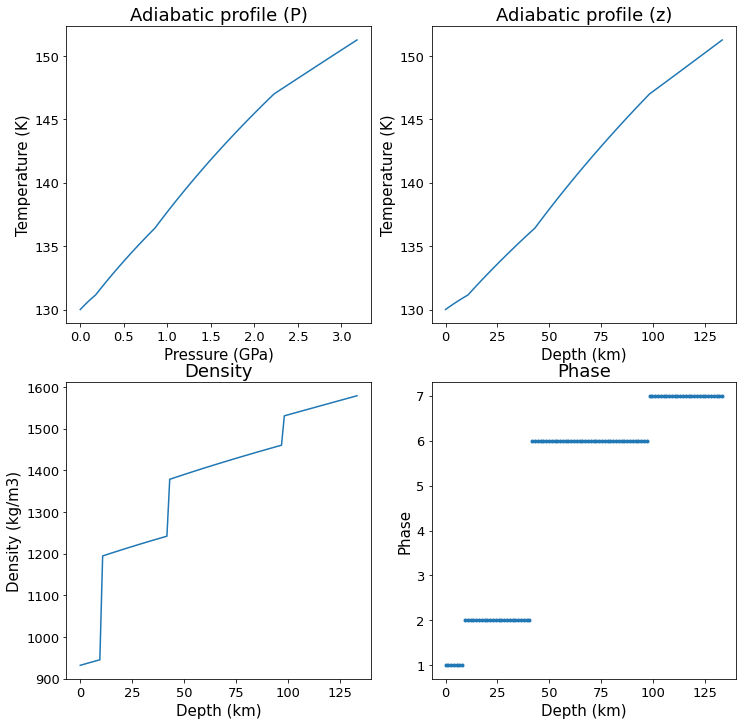

In [38]:
if plot_flg == 1:  
    font = {'family' : 'normal',
            'size'   : 15}

    plt.rc('font', **font)
    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13) 
    
    
    fig = plt.figure(figsize=(12,12))
    plt.subplots_adjust(wspace=0.2 , hspace=0.2)
    plt.subplot(221)
    plt.xlabel('Pressure (GPa)')
    plt.ylabel('Temperature (K)')
    plt.title('Adiabatic profile (P)')
    plt.plot(P*1e-3, T, '-')

    plt.subplot(222) 
    plt.xlabel('Depth (km)')
    plt.ylabel('Temperature (K)')
    plt.title('Adiabatic profile (z)')
    plt.plot(z*1e-3, T, '-')

    plt.subplot(223)  
    plt.xlabel('Depth (km)')
    plt.ylabel('Density (kg/m3)')
    plt.title('Density')
    plt.plot(z*1e-3, rho, '-')

    plt.subplot(224)  
    plt.xlabel('Depth (km)')
    plt.ylabel('Phase')
    plt.title('Phase')
    plt.plot(z*1e-3, phase, '.')
    plt.savefig('/Users/tgordon/Desktop/ice-VII.pdf')